# Creating, Evaluating, and Deploying a Time Series Forecasting Model

## Introduction

This notebook shows the Microsoft Fabric end-to-end data science workflow for a time series forecasting model. This scenario uses historic sales data to predict the total monthly sales of properties in New York City.

Time series forecasting predicts future values, based on historical data. This is a common, important part of business operations. This notebook shows tools and methods that can apply to other forecasting tasks: weather, sales numbers, stock prices, capacity planning, etc. 

This notebook covers these topics:

1. Custom library installation
2. Load and process the data
3. Examine the data with exploratory data analysis
4. Train a machine learning model with Prophet - an open source software package
5. Save the final machine learning model, and make predictions

## Prerequisites

[!INCLUDE [prerequisites](./includes/prerequisites.md)]

* If you don't have a Microsoft Fabric lakehouse, create one by following the steps in [Create a lakehouse in Microsoft Fabric](../data-engineering/create-lakehouse.md).

## Follow along in the notebook

The [AIsample - Time Series Forecasting](lGitHub link here) notebook accompanies this tutorial.

[!INCLUDE [follow-along](./includes/follow-along.md)]

<mark></mark>
## Step 1: Install Custom Libraries

For machine learning model development, or ad-hoc data analysis, you may need to quickly install a custom library for your Apache Spark session. To do so, use

**%pip install**

or

**%conda install**

for the library installation. As another method, you can also install the required libraries in the workspace. For this method, navigate to the workspace setting to find Library management.

In this tutorial, use

**%pip install prophet**

to install the [Prophet](https://facebook.github.io/prophet/) open source library.

In [ ]:
%pip install prophet

## Step 2: Load and Process the Data

At the [NYC Open Data Portal](https://opendata.cityofnewyork.us/), the NYC Department of Finance published the [NYC Property Sales data](https://www1.nyc.gov/site/finance/about/open-portal.page) dataset. This notebook uses that dataset. 

The dataset includes a record of every building sale in the New York City property market, within a thirteen year period. Refer to the [Glossary of Terms for Property Sales Files](https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf) for a definition of the columns in the dataset.

|borough|neighborhood|building_class_category|tax_class|block|lot|eastment|building_class_at_present|address|apartment_number|zip_code|residential_units|commercial_units|total_units|land_square_feet|gross_square_feet|year_built|tax_class_at_time_of_sale|building_class_at_time_of_sale|sale_price|sale_date|
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|Manhattan|ALPHABET CITY|07  RENTALS - WALKUP APARTMENTS|0.0|384.0|17.0||C4|225 EAST 2ND   STREET||10009.0|10.0|0.0|10.0|2145.0|6670.0|1900.0|2.0|C4|275000.0|2007-06-19|
|Manhattan|ALPHABET CITY|07  RENTALS - WALKUP APARTMENTS|2.0|405.0|12.0||C7|508 EAST 12TH   STREET||10009.0|28.0|2.0|30.0|3872.0|15428.0|1930.0|2.0|C7|7794005.0|2007-05-21|

We want to build a model that forecasts the monthly total sales, based on historical data. For this, we use [Facebook Prophet](https://facebook.github.io/prophet/), an open source forecasting library developed by Facebook. It is based on an additive model, where non-linear trends are fit with daily, weekly, and yearly seasonality, and holiday effects. Prophet works best with data resources that span several seasons of historical data, and that additionally have strong seasonal effects. Additionally, Prophet robustly handles missing data, and data outliers.

Prophet uses a decomposable time series model, consisting of these three components:
- **trend**: Prophet assumes a piece-wise constant rate of growth, with automatic change point selection
- **seasonality**: By default, Prophet uses Fourier Series to fit weekly and yearly seasonality
- **holidays**: Prophet requires all past and future occurrences of holidays. If a holiday doesn't repeat in the future, Prophet will not include it in the forecast.

We'll aggregate our data on a monthly basis, so we will ignore the holidays.

Read [the official paper](https://peerj.com/preprints/3190/) for more information about the Prophet modeling techniques.

### Download the dataset, and upload to Lakehouse

The dataset has fifteen CSV-format files. These files contain property sales records from 5 boroughs in New York between 2003 and 2015. For convenience, these files are compressed in the `nyc_property_sales.tar` file. This file is a publicly-available blob storage.

In [5]:
URL = "https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/"
TAR_FILE_NAME = "nyc_property_sales.tar"
DATA_FOLDER = "Files/NYC_Property_Sales_Dataset"
TAR_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/tar/"
CSV_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/csv/"

EXPERIMENT_NAME = "aisample-timeseries" # Mlflow experiment name

This code download a publicly-available version of the dataset, and then stores that dataset in a Fabric Lakehouse.

**Be sure to add a lakehouse to the notebook before you run it. An error will result if you don't do this.**

[This resource](https://aka.ms/fabric/addlakehouse) describes how to add a lakehouse to a notebook.

In [ ]:
import os

if not os.path.exists("/lakehouse/default"):
    # Add a lakehouse if the notebook has no default lakehouse
    # By default, a new notebook will not link to any lakehouse
    raise FileNotFoundError(
        "Default lakehouse not found, please add a lakehouse for the notebook."
    )
else:
    # Verify whether or not the required files are already
    # in the lakehouse; if not, download and unzip
    if not os.path.exists(f"{TAR_FILE_PATH}{TAR_FILE_NAME}"):
        os.makedirs(TAR_FILE_PATH, exist_ok=True)
        os.system(f"wget {URL}{TAR_FILE_NAME} -O {TAR_FILE_PATH}{TAR_FILE_NAME}")

    os.makedirs(CSV_FILE_PATH, exist_ok=True)
    os.system(f"tar -zxvf {TAR_FILE_PATH}{TAR_FILE_NAME} -C {CSV_FILE_PATH}")

Record the notebook running time.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

#### Set up the MLflow experiment tracking

To extend the MLflow logging capabilities, autologging automatically captures the values of input parameters and output metrics of a machine learning model during its training. This information is then logged to the workspace, where the MLflow APIs or the corresponding experiment in the workspace can access and visualize it. Visit [this resource](https://aka.ms/fabric-autologging) for more information about autologging.

In [ ]:
# Set up the Mlflow experiment
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable Mlflow autologging

To disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()`, and set `disable=True`

### Read raw date data from the lakehouse

In [ ]:
df = (
    spark.read.format("csv")
    .option("header", "true")
    .load("Files/NYC_Property_Sales_Dataset/csv")
)

## Step 3: Exploratory Data Analysis

To review the dataset, you should manually examine a data subset for a better understanding of the data. You can use the `display` function to print the DataFrame. You can also show the **Chart** views, to easily visualize subsets of the dataset.

In [ ]:
display(df)

Some of the early observations based on manually going through the dataset include:

- Instances of $0.00 sales prices. According to the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf), this implies a transfer of ownership no cash consideration. In other words, no cash flowed in the transaction. **We should remove sales with $0.00 `sales_price` values from the dataset.**

- This dataset covers different building classes. However, in this notebook, we will only focus on residential buildings which, according to the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf), are marked as type "A". **We should filter the dataset to include only residential buildings.** To do this, include either the `building_class_at_time_of_sale` or the `building_class_at_present`. Here, we will include only `building_class_at_time_of_sale` data.

- The dataset includes data `total_units` values equal to 0, or `gross_square_feet` values equal to 0. **We should remove all instances with `total_units` or `gross_square_units` values equal to 0.**

- Some columns have missing or NULL values, e.g.,  the `apartment_number`, `tax_class`, `build_class_at_present`. We can assume that the missing data involves clerical errors, or non-existent data. Our analysis does not depend on these missing values, so we can ignore them.

- The `sale_price` column is stored as a string, with a prepended "$". To proceed with our analysis, represent this column as a number. **We should cast the `sale_price` column as integer.**

#### Type Conversion and Filtering
To resolve some of the issues identified above, first import required libraries.

In [ ]:
# Import libraries
import pyspark.sql.functions as F
from pyspark.sql.types import *

**Cast the sales data from string to integer**

Use regular expressions to separate the numeric portion of the string from the dollar sign (e.g., in the string "\$300,000", split "$" and "300,000"), and then cast the numeric portion as an integer.

**Next, filter the data to only include instances that meet all of these conditions:**

1. The `sales_price` is greater than 0
2. The `total_units` is greater than 0
3. The `gross_square_feet` is greater than 0
4. The `building_class_at_time_of_sale` is of type A

In [ ]:
df = df.withColumn(
    "sale_price", F.regexp_replace("sale_price", "[$,]", "").cast(IntegerType())
)
df = df.select("*").where(
    'sale_price > 0 and total_units > 0 and gross_square_feet > 0 and building_class_at_time_of_sale like "A%"'
)

#### Aggregation on monthly basis

The data resource tracks property sales on a daily basis, but this is too granular for what we want to do here. Instead, we should aggregate our data on a monthly basis.

First, change the date values to show only month and year data. Note that this data would still include the year values. We could still distinguish between, for example, December 2005 and December 2006.

Additionally, we'll only keep the columns relevant to our analysis. These include `sales_price`, `total_units`, `gross_square_feet` and `sales_date`. We'll rename `sales_date` to `month`.

In [ ]:
monthly_sale_df = df.select(
    "sale_price",
    "total_units",
    "gross_square_feet",
    F.date_format("sale_date", "yyyy-MM").alias("month"),
)
display(monthly_sale_df)

Aggregate the `sale_price`, `total_units` and `gross_square_feet` values by month. Then, group the data by `month`, and sum all the values within each group. 

In [ ]:
summary_df = (
    monthly_sale_df.groupBy("month")
    .agg(
        F.sum("sale_price").alias("total_sales"),
        F.sum("total_units").alias("units"),
        F.sum("gross_square_feet").alias("square_feet"),
    )
    .orderBy("month")
)

display(summary_df)

#### Pyspark to Pandas Conversion

Pyspark DataFrames handle large datasets really well. However, due to data aggregation, the DataFrame size is much smaller, suggesting that we can now use Pandas DataFrames.

In the following, we cast the dataset from a Pyspark DataFrame to a Pandas DataFrame.

In [ ]:
import pandas as pd

df_pandas = summary_df.toPandas()
display(df_pandas)

#### Visualization

To better understand the data, we'll examine the property trade trend of New York City. This helps gain insight into the patterns and seasonality trends that might exist. Learn more about Microsoft Fabric data visualization [here](https://aka.ms/fabric/visualization).

StatementMeta(, 62c0d433-0d7d-47d7-8b3e-7d2d0039de4c, 20, Finished, Available)

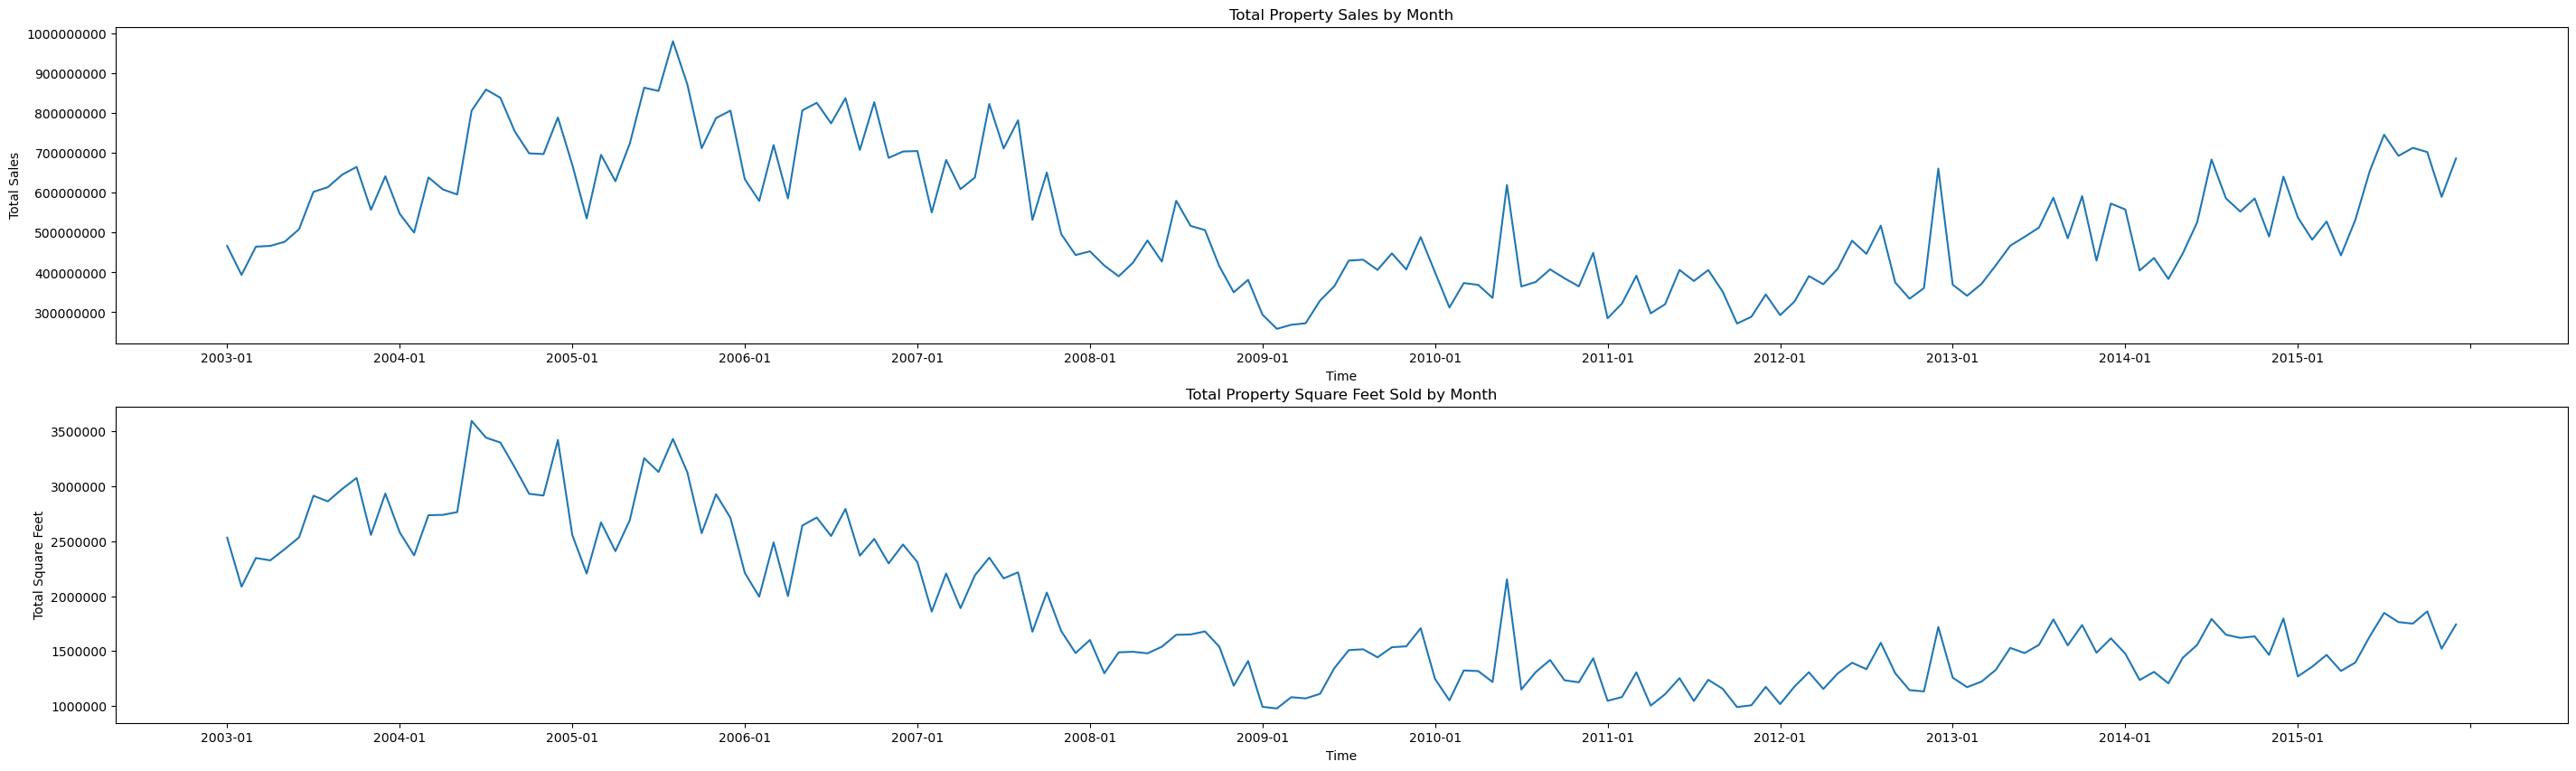

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 10))
plt.sca(ax1)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="total_sales", data=df_pandas)
plt.ylabel("Total Sales")
plt.xlabel("Time")
plt.title("Total Property Sales by Month")

plt.sca(ax2)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="square_feet", data=df_pandas)
plt.ylabel("Total Square Feet")
plt.xlabel("Time")
plt.title("Total Property Square Feet Sold by Month")
plt.show()

#### Summary of observations from the exploratory data analysis

- The data shows a clear recurring pattern on a yearly cadence; this means we found a **yearly seasonality**
- The summer months seem to have higher sales volumes compared to winter months
- If we compare years with high sales and years with low sales, the revenue difference between high sales months and low sales months in high sales years exceeds - in absolute terms - the revenue difference between high sales months and low sales months. For example, in 2004, the revenue difference between the highest sales month and the lowest sales month is about

  $900,000,000 - $500,000,000 =

        $400,000,000

  and for 2011, that revenue difference calculation is about

  $400,000,000 - $300,000,000 =

        $100,000,000

  This becomes important later, when we must decide between **multiplicative** and **additive** seasonality effects.

## Step 4: Model Training and Tracking

### Model Fitting

Input for the [Prophet](https://facebook.github.io/prophet/) is always a two-column DataFrame. One input column is a time column named `ds`, and one input column is a value column named `y`. The time column should have a date, time, or datetime data format (for example, YYYY_MM). Our data here meets that condition. The value column must have a numerical data format.

For our model fitting, we must only rename the time column to `ds` and value column to `y`, and pass the data to Prophet. Read the [Prophet Python API documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api) for more information.

In [ ]:
df_pandas["ds"] = pd.to_datetime(df_pandas["month"])
df_pandas["y"] = df_pandas["total_sales"]

Prophet follows the same convention as [sklearn](https://scikit-learn.org/). First, create a new instance of Prophet, set certain parameters (for example, `seasonality_mode`), and then fit that instance to the dataset.

- Although a constant additive factor is the default seasonality effect for Prophet, we should use the **'multiplicative' seasonality** parameter value. Our analysis in the previous section showed that due to changes in seasonality amplitude, a simple additive seasonality won't fit the data well at all.

- Set **weekly_seasonality** parameter to **off**, because we aggregated the data by month and we do not have weekly data.

- Use the **Markov Chain Monte Carlo (MCMC)** parameter to capture the seasonality uncertainty estimates. By default, Prophet can provide uncertainty estimates on the trend and observation noise, but not for the seasonality. MCMC needs more time, but it allows the algorithm to provide uncertainty estimates on the seasonality, as well as the trend and observation noise. Read the [Prophet Uncertainty Intervals documentation](https://facebook.github.io/prophet/docs/uncertainty_intervals.html) for more information.

- We can tune the automatic change point detection sensitivity through the **changepoint_prior_scale** parameter. The Prophet algorithm automatically tries to find instances in the data where the trajectories abruptly change. It can become difficult to find the correct value. To proceed, try different values and select the best performing model. Read the [Prophet Trend Changepoints documentation](https://facebook.github.io/prophet/docs/trend_changepoints.html) for more information.

In [ ]:
from prophet import Prophet

def fit_model(dataframe, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples):
    m = Prophet(
        seasonality_mode=seasonality_mode,
        weekly_seasonality=weekly_seasonality,
        changepoint_prior_scale=chpt_prior,
        mcmc_samples=mcmc_samples,
    )
    m.fit(dataframe)
    return m

### Cross Validation

Prophet has a built-in cross-validation tool. This tool can estimate the forecasting error, and find the model with the best performance.

The cross-validation technique can validate model efficiency. This technique trains the model on a subset of the dataset, and runs tests on a previously-unseen subset of the dataset. This technique can check how well a statistical model generalizes to an independent dataset.

For cross-validation, we reserve a particular sample of the dataset, which was not part of the training dataset. Then, we test the trained model on that sample prior to deployment. However, this approach does not work for time-series data, because if the model has seen data from January 2005, and March 2005, and we try to predict February 2005, the model can "cheat" in a way, because it could see where the data trend is going. In real applications, we are forecasting into the **_future_**, as the unseen regions. 

To handle this challenge, and make our test reliable, split the dataset based on the dates. Use the dataset up to a certain date (i.e., the first eleven years of data) for training, and then use the remaining unseen data for prediction.

In this scenario, start with eleven years of training data, and then make monthly predictions using a 1-year horizon. Specifically, our training data contains everything from 2003 through 2013. Then, our first run will handle predictions for January 2014 through January 2015. The next run handles predictions for February 2014 through February 2015, and so on.

We'll repeat this process for each of our three models, to see which model performed the best. Then, we'll compare these predictions with real-world values to establish the prediction quality of our best model.

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

def evaluation(m):
    df_cv = cross_validation(m, initial="11 Y", period="30 days", horizon="365 days")
    df_p = performance_metrics(df_cv, monthly=True)
    future = m.make_future_dataframe(periods=12, freq="M")
    forecast = m.predict(future)
    return df_p, future, forecast

### Log Model with MLflow

We log the models to keep track of their parameters, and save the models for later use. All relevant model information is logged in the workspace, under the experiment name.

In [ ]:
# Setup Mlflow
from mlflow.models.signature import infer_signature

### Conduct Experiments

A machine learning experiment serves as the primary unit of organization and control, for all related machine learning runs. A run corresponds to a single execution of model code. Machine learning experiment tracking refers to the management of all the different experiments and their components

- parameters 
- metrics
- models
- other artifacts

and it allows for the organization of all the the required components of a specific machine learning experiment. Machine learning experiment tracking also allows for the easy duplication of past results with saved experiments. Learn more about machine learning experiments in Microsoft Fabric [here](https://aka.ms/synapse-experiment).
Finally, after we determine the steps we intend to include, we can run the experiment. This involves fitting and evaluating the Prophet model. The model, parameters, and metrics, along with MLFlow autologging items, will be saved in one MLFlow run.

In [ ]:
model_name = f"{EXPERIMENT_NAME}-prophet"

models = []
df_metrics = []
forecasts = []
seasonality_mode = "multiplicative"
weekly_seasonality = False
changepoint_priors = [0.01, 0.05, 0.1]
mcmc_samples = 100

for chpt_prior in changepoint_priors:
    with mlflow.start_run(run_name=f"prophet_changepoint_{chpt_prior}"):
        # init model and fit
        m = fit_model(df_pandas, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples)
        models.append(m)
        # validation
        df_p, future, forecast = evaluation(m)
        df_metrics.append(df_p)
        forecasts.append(forecast)
        # log model and parameters with mlflow
        mlflow.prophet.log_model(
            m,
            model_name,
            registered_model_name=model_name,
            signature=infer_signature(future, forecast),
        )
        mlflow.log_params(
            {
                "seasonality_mode": seasonality_mode,
                "mcmc_samples": mcmc_samples,
                "weekly_seasonality": weekly_seasonality,
                "changepoint_prior": chpt_prior,
            }
        )
        metrics = df_p.mean().to_dict()
        metrics.pop("horizon")
        mlflow.log_metrics(metrics)

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/Timeseries-experiment.png"  width="70%" height="30%">

### Model Visualization with Prophet

Prophet has built-in visualization functions which can be used to show the model fitting results. 

The black dots denote the data points that are used to train the model. The blue line is the prediction, and the light blue area shows the uncertainty intervals. Note that we have built three models with varying levels of `changepoint_prior_scale`. The predictions of these three models are shown below.

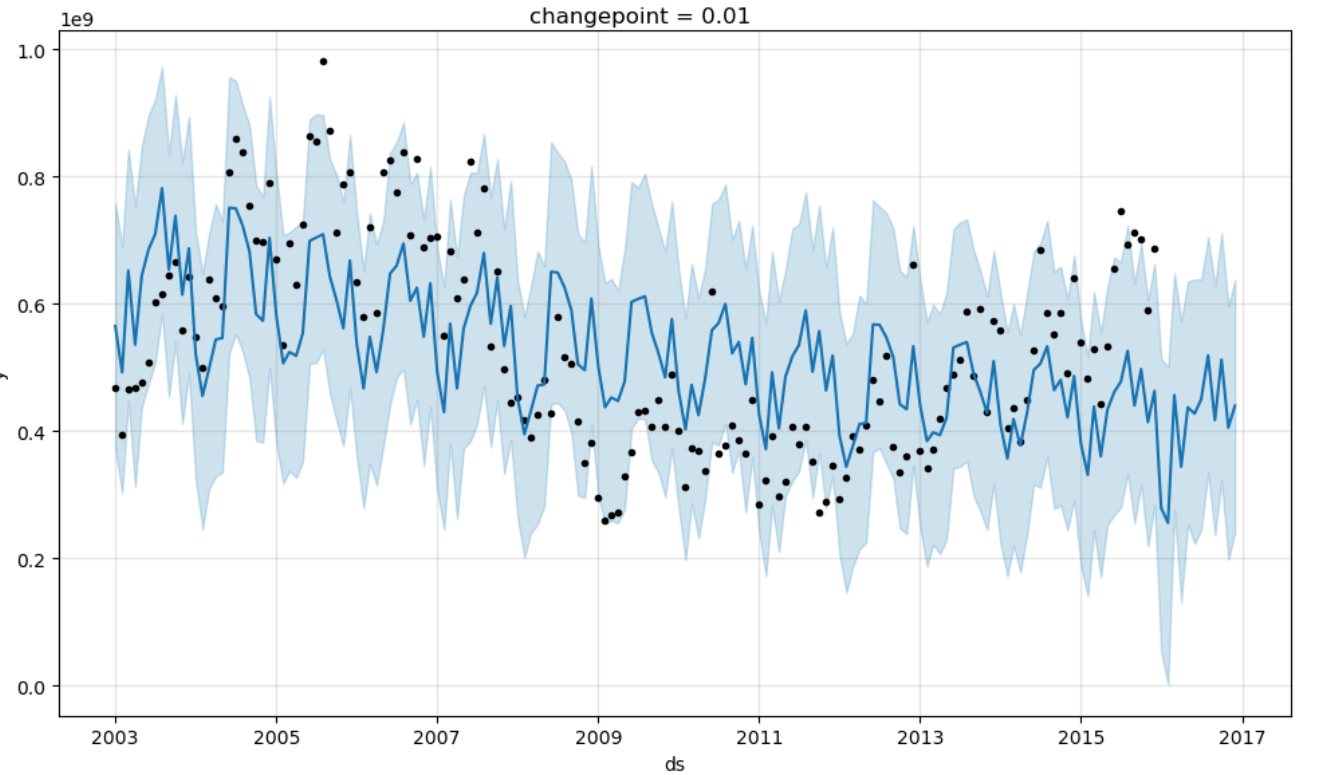

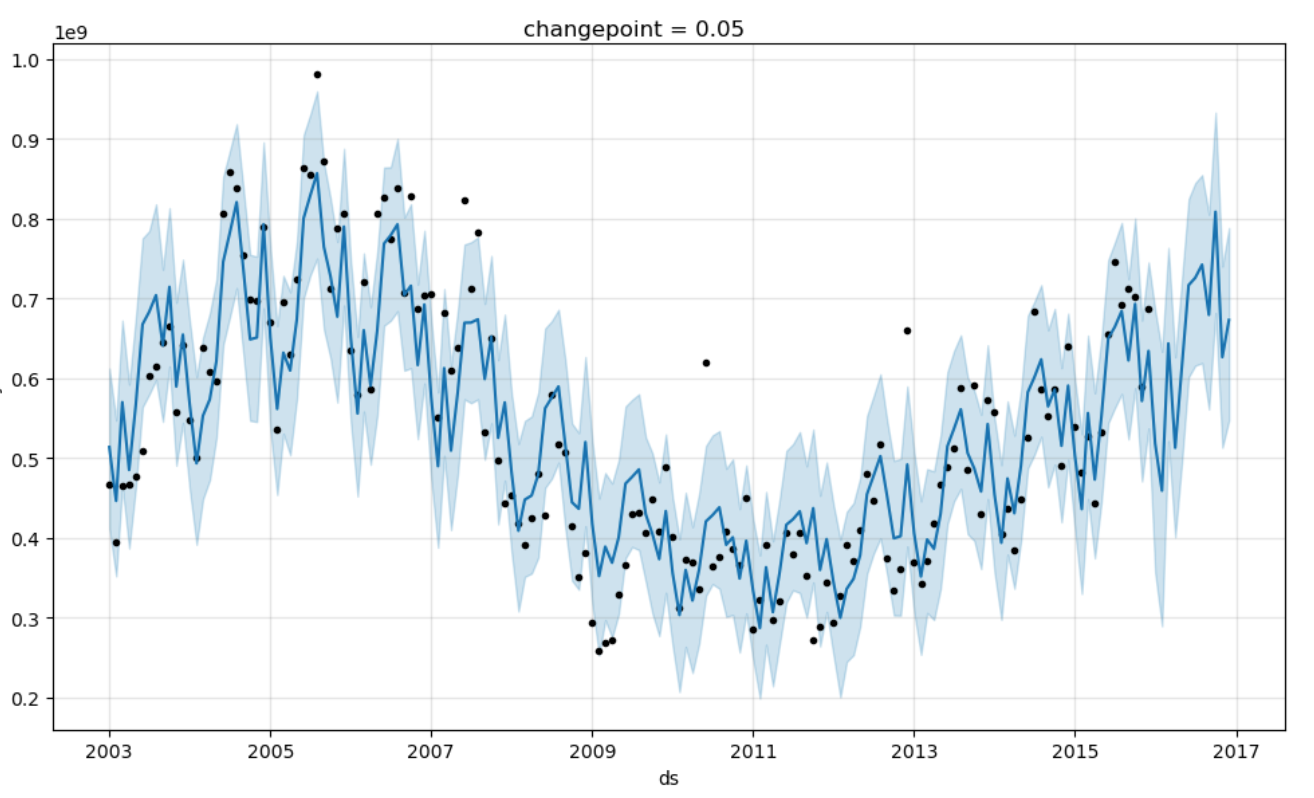

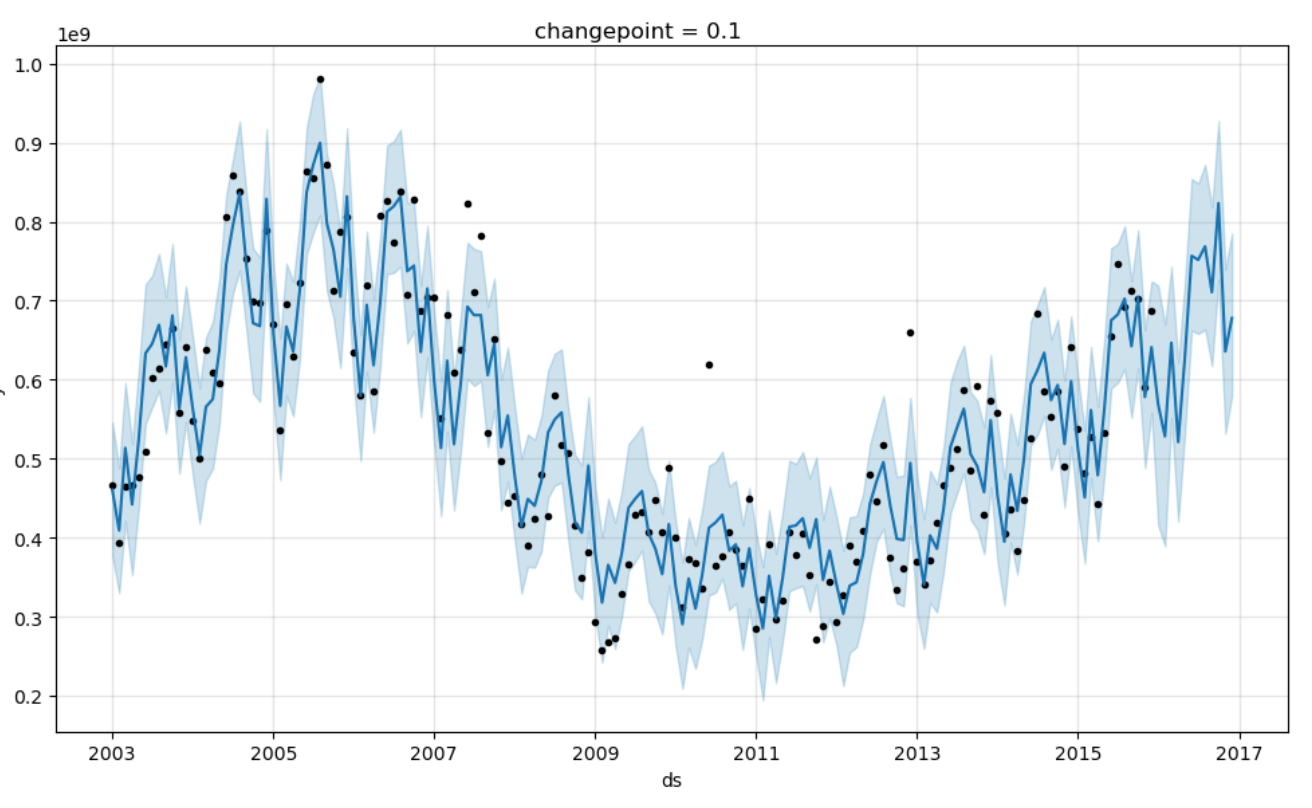

In [ ]:
for idx, pack in enumerate(zip(models, forecasts)):
    m, forecast = pack
    fig = m.plot(forecast)
    fig.suptitle(f"changepoint = {changepoint_priors[idx]}")

The smallest `changepoint_prior_scale` value in the first graph leads to an underfitting of trend changes. The largest `changepoint_prior_scale` in the third graph may result in overfitting. Consequently, the second graph seems to be the optimal choice. This implies that the second model is the most suitable.

### Visualize trend and seasonality with Prophet

Prophet can easily visualize underlying trends and seasonalities. Visualizations of the second model are shown below.

In [ ]:
BEST_MODEL_INDEX = 1  # set best model index according to the previous results
fig2 = models[BEST_MODEL_INDEX].plot_components(forecast)

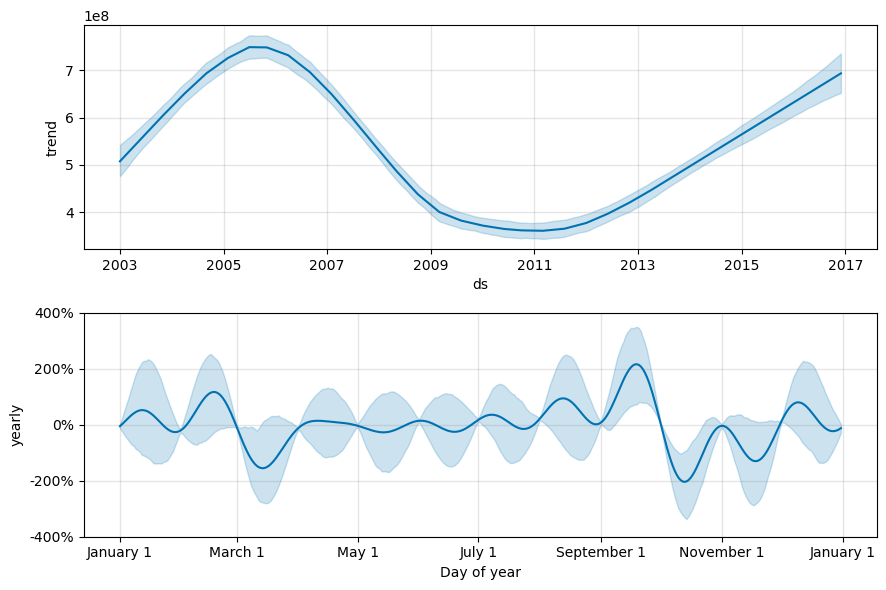

In these graphs, the light blue shading reflects the uncertainty. The top graph shows a strong, long-period oscillating trend. Over a few years, the sales volumes rise and fall. The lower graph shows that sales tend to peak in February and September, reaching their maximum values for the year in those momths. Shortly after those months, in March and October, they plunge to the year's minimum values.

We can evaluate the performance of the models using various metrics
- mean squared error (MSE)
- root mean squared error (RMSE)
- mean absolute error (MAE)
- mean absolute percent error (MAPE)
- median absolute percent error (MDAPE)
- symmetric mean absolute percentage error (SMAPE)
- coverage of the `yhat_lower` and `yhat_upper` estimate

Note the varying horizons where we predict one year in the future, twelve times.

In [ ]:
display(df_metrics[BEST_MODEL_INDEX])

With the MAPE metric, we note that for this forecasting model, predictions extending one month into the future typically involve errors of roughly 8%. However, for predictions one year into the future, the error increases to around 10%.

## Step 5: Deploy model and save prediction results

We will now deploy the model, and save the prediction results.


#### Prediction with Predict Transformer

Now, we can load the model and use it to make predictions. Users can operationalize machine learning models with **PREDICT**, a scalable Microsoft Fabric function that supports batch scoring in any compute engine. You can learn more about ```PREDICT```, and how to use it within Microsoft Fabric, at [this resource](https://aka.ms/fabric-predict).

In [ ]:
from synapse.ml.predict import MLFlowTransformer

spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=future.columns.values,
    outputCol="prediction",
    modelName=f"{EXPERIMENT_NAME}-prophet",
    modelVersion=BEST_MODEL_INDEX,
)

test_spark = spark.createDataFrame(data=future, schema=future.columns.to_list())

batch_predictions = model.transform(test_spark)

display(batch_predictions)

In [ ]:
# Code for saving predictions into lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions"
)

In [ ]:
print(f"Full run cost {int(time.time() - ts)} seconds.")